In [ ]:
 !pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from pydlm import dlm, trend, seasonality, dynamic
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

In [89]:
data = pd.read_csv('TM-1.csv')

In [90]:
data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

<ipython-input-90-0ec218d4fe38>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,Open,High,Low,Close,Adj Close,Volume
Open,1.0,0.99972,0.99964,0.99937,0.99152,-0.23053
High,0.99972,1.0,0.99955,0.99968,0.99169,-0.22494
Low,0.99964,0.99955,1.0,0.9997,0.99186,-0.23644
Close,0.99937,0.99968,0.9997,1.0,0.99195,-0.22946
Adj Close,0.99152,0.99169,0.99186,0.99195,1.0,-0.27531
Volume,-0.23053,-0.22494,-0.23644,-0.22946,-0.27531,1.0


In [91]:
df = pd.DataFrame(data)

In [92]:
df = df[['Close','High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [102]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [103]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [104]:
from pydlm import dlm, trend, autoReg, dynamic

# Assuming train_data and y_train are already defined

high_feature = []
for price in train_data['High']:
    high_feature.append([price])

# Define the DLM model
myDLM = dlm(y_train)

# Add a linear trend component with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)

# Add an autoregressive component with a prior covariance of 1e7
myDLM = myDLM + autoReg(degree=1, data=y_train, name='ar1', w=1e7)

# Add a dynamic component with the high_feature
myDLM = myDLM + dynamic(features=high_feature, discount=1, name='High')

# Fit the DLM model
myDLM.fit()

# Print the fitted model
print(myDLM)

/usr/local/lib/python3.10/dist-packages/pydlm/modeler/autoReg.py:75: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [105]:
# Quá trình testing, and predict test
x_test= []
for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Close'])
y_test_pred = myDLM.predictN(date = myDLM.n-1, N=len(x_test),featureDict={'High': x_test})
y_test_pred = y_test_pred[0]

(600, 1)


In [106]:
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MAPE:", mape * 100)
print("RMSE:", rmse)

MAE: 19.31705146696518
MAPE: 11.287848917921394
RMSE: 24.31693878068898


In [107]:
#Quá trình validate, and predict val
y_val = np.array(val_data['High'])
x_val= []
for price in val_data['High']:
  x_val.append([price])
print(type(x_val))
size = test_size + val_size
y_pred_val = myDLM.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[123.21307584268304, 123.26676518630612, 123.27988626298205, 123.329291463361, 123.42227631848561, 123.5523611580703, 123.56717952548912, 123.60307242373439, 123.65790773369821, 123.69449437195523, 123.77598196784164, 123.81941238142284, 123.88823534917606, 123.93615696072321, 124.00259945106735, 124.02956998539776, 124.06338591297832, 124.14174355161319, 124.17897016704254, 124.2621260705505, 124.37073166709372, 124.44007528887823, 124.4734768009538, 124.57395427615799, 124.61611609540759, 124.64977580558836, 124.71429269117982, 124.73313515269986, 124.82313779985807, 124.87300112935904, 124.95323138509607, 124.9575927309399, 125.10954524246029, 125.21016409663955, 125.26031075527132, 125.34928788423214, 125.3684450171185, 125.4256032127912, 125.49369194196113, 125.5382012143347, 125.64748515747071, 125.7212254652319, 125.81415150191062, 125.84798952490019, 125.87889973480108, 125.97288964224497, 126.03235230149346, 126.0575582206629, 126.08400458807057, 126.10813110546

In [108]:
# Thực hiện dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])

#Quá trình testing
x_test_LR = np.array(test_data.index).reshape(-1, 1)
y_test_LR = np.array(test_data['High'])
y_pred_LR = LR_model.predict(x_test_LR)

# Quá trình Validate
x_val_LR= np.array(val_data.index).reshape(-1, 1)
y_val_LR = np.array(val_data)
y_pred_val_LR =  LR_model.predict(x_val_LR)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = LR_model.predict(feature_next_30_days)

print(feature_next_30_days)

[150.34902161 150.36615619 150.38329077 150.40042535 150.41755993
 150.4346945  150.45182908 150.46896366 150.48609824 150.50323282
 150.5203674  150.53750198 150.55463656 150.57177114 150.58890572
 150.6060403  150.62317488 150.64030946 150.65744404 150.67457862
 150.6917132  150.70884778 150.72598235 150.74311693 150.76025151
 150.77738609 150.79452067 150.81165525 150.82878983 150.84592441]


In [109]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x = []
for price in feature_next_30_days:
  x.append([price])
print(type(x))
num_dims = np.ndim(x)
print(num_dims)
y_next_30_days = myDLM.predictN(featureDict={'High': x}, N = 30)
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)

<class 'list'>
2
[123.469216480734, 123.48358870028838, 123.54721235012505, 123.60400007226508, 123.66173659745925, 123.71934143208043, 123.77696454489637, 123.83458512076224, 123.89220604874802, 123.94982692786077, 124.0074478137569, 124.06506869871154, 124.12268958379687, 124.18031046886404, 124.23793135393373, 124.29555223900309, 124.35317312407247, 124.41079400914187, 124.46841489421126, 124.52603577928063, 124.58365666435003, 124.6412775494194, 124.6988984344888, 124.7565193195582, 124.81414020462756, 124.87176108969697, 124.92938197476636, 124.98700285983574, 125.04462374490512, 125.10224462997454]


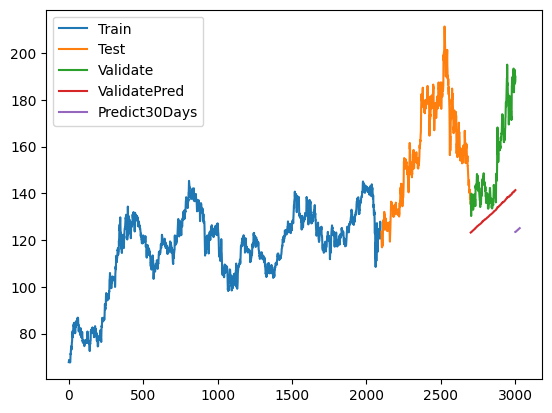

In [110]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index,val_data['Close'])
plt.plot(val_data.index,y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()